# ASSIGNMENT:
Being a Machine Learning Engineer, your task is to analyse and pre-process the data using appropriate machine learning techniques. Later, to propose and develop a machine learning model, i) to predict future energy consumption for each country, and ii) to forecast the level of carbon emission by each country. You are required to present/visualise energy consumption and carbon emission trends for at least three countries and for the next five years, where any change in both should be critically justified in the report using the evidence provided in the dataset for that country. A typical machine learning workflow involves, data pre-processing, selection and training of model, model evaluation, visualization, and deployment for future prediction.


# OBJECTIVE:
Predict the carbon emissions and energy consumption.

# KEY FEATURES:

*   ***Entity:*** The name of the country or region for which the data is reported (RELEVANT TO THE INVESTIGATION).

*   ***Year:*** The year for which the data is reported, ranging from 2000 to 2020 (RELEVANT TO THE INVESTIGATION).

*   ***Access to electricity (% of population):*** The percentage of population with access to electricity (RELEVANT TO THE ELECTRICITY FORCASTING).

*   ***Access to clean fuels for cooking (% of population):*** The percentage of the population with primary reliance on clean fuels (RELEVANT TO THE INVESTIGATION).

*   ***Renewable-electricity-generating-capacity-per-capita:*** Installed Renewable energy capacity per person

*   ***Financial flows to developing countries (US $):*** Aid and assistance from developed countries for clean energy projects.

*   ***Renewable energy share in total final energy consumption (%):*** Percentage of renewable energy in final energy consumption.

*   ***Electricity from fossil fuels (TWh):*** Electricity generated from fossil fuels (coal, oil, gas) in terawatt-hours.

*   ***Electricity from nuclear (TWh):*** Electricity generated from nuclear power in terawatt-hours.

*   ***Electricity from renewables (TWh):*** Electricity generated from renewable sources (hydro, solar, wind, etc.) in terawatt-hours.

*   ***Low-carbon electricity (% electricity):*** Percentage of electricity from low-carbon sources (nuclear and renewables).

*   ***Primary energy consumption per capita (kWh/person) -- (TARGET):*** Energy consumption per person in kilowatt-hours.

*   ***Energy intensity level of primary energy (MJ/$2011 PPP GDP):*** Energy use per unit of GDP at purchasing power parity.

*   ***Value_co2_emissions (metric tons per capita) -- (TARGET):*** Carbon dioxide emissions per person in metric tons.

*   ***Renewables (% equivalent primary energy):*** Equivalent primary energy that is derived from renewable sources.

*   ***GDP growth (annual %):*** Annual GDP growth rate based on constant local currency.

*   ***GDP per capita:*** Gross domestic product per person.

*   ***Density (P/Km2):*** Population density in persons per square kilometer.

*   ***Land Area (Km2):*** Total land area in square kilometers.

*   ***Latitude:*** Latitude of the country's centroid in decimal degrees.

*   ***Longitude:*** Longitude of the country's centroid in decimal degrees.

## Predict future energy consumption and forecast carbon emission level for three countries and for the next five years. Use appropriate visualization to showcase the performance of chosen model for both predication and forecasting tasks. Discuss results.

In [1]:
# LIBRARIES:https://www.kaggle.com/code/sergiykobtsev/energy-consumption-eda/notebook

# MOUNTING THE GOOGLE COLAB TO GET THE VIRTUAL ENVIRONMENT AND THE DATA FRAME
from google.colab import drive
drive.mount('/content/drive')

# LIBRARIES ARE INSTALLED IN A VIRTUAL INVIRONMENT SO I NEED TO IMPORT THE VIRTUAL ENVIRONMENT
import sys
sys.path.append('/content/drive/MyDrive/colab_env/lib/python3.10/site-packages')

# DATA HANLDING AND NUMERICAL OPERATIONS
import pandas as pd
import numpy as np

# SHOWCASTING THE DATA:
pd.set_option("display.max_column", None)
pd.set_option('display.max_rows', None)

# GRAPHS:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ENCODERS:
from sklearn.preprocessing import LabelEncoder

# MODELS
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.forecasting.arima import AutoARIMA

Mounted at /content/drive


In [2]:
# FUNTIONS:
def NaNs_calculator(data):

    '''SHOWING THE STATS OF MISSING DATA AND DATA TYPE'''

    percentage_missing = (data.isna().mean()*100).sort_values(ascending = False)                      # Storing the Percentages of NaNs
    sum_missing = data.isna().sum().sort_values(ascending = False)                                    # Storing the Sum of NaNs
    names = sum_missing.index.to_list()                                                               # Storing names (to show in the columns)
    data_type = data[names].dtypes                                                                    # Storing the type of data based on the order from the previous obtained data (slicing)
    sum_values = sum_missing.to_list()                                                                # Getting count of missing values
    perc_values = np.around(percentage_missing.to_list(), 3)                                          # Getting percentage of missing values
    types = data_type.to_list()                                                                       # Getting the types of the data
    # TURN ALL THE DATA INTO A DATAFRAME
    df_missing = pd.DataFrame({"NAMES" : names,
                                    "VALUE COUNT" : sum_values,
                                    "PERCENTAGE (%)" : perc_values,
                                    "DATA TYPE": types})
    return df_missing

def country_to_continent(country_name):
  '''# TAKES A COUNTRY NAME AS INPUT TO SORT THEM INTO CONTINENT FOR EASIER ANALYSIS'''

  # CONVERT THE COUNTRY NAME TO ISO 3166-1 ALPHA-2 COUNTRY CODE (ABBREVIATION, E.G. COLOMBIA = CO)
  country_alpha2 = pc.country_name_to_country_alpha2(country_name)

  # USE THE COUNTRY CODE TO GET THE CONTINENT CODE (E.G., 'NA' FOR NORTH AMERICA)
  country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)

  # CONVERT THE CONTINENT CODE TO THE FULL CONTINENT NAME (E.G., 'NORTH AMERICA')
  country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)

  return country_continent_name

def filter_and_calculate_mean(data, year, column_name, cols):
  '''CREATING A FUNCTION TO AUTOMATICALLY CALCULATE THE AVERAGE VALUE FOR THE CONTINENT FOR THE YEAR.
  TAKING 4 ARGUMENTS:
  1. FULL DATA FRAME
  2. TIME FRAME
  3. COLUMN NAME (CO2 OR ENERGY)
  4. COLUMS TO HANDLE'''
  row_data = {'Year': year}
  for continent in cols:
      filtered_df = data[(data['Year'] == year) & (data['Continent'] == continent)]
      mean_value = filtered_df[column_name].mean()
      row_data[continent] = mean_value
  return row_data

def plot_trend(country_1, country_2, country_3, years, title):

  '''THIS FUNCTION WILL PLOT THE TREND TAKING 5 PARAMETERS:
    1. TAKEN THE DATA FROM 3 COUNTRIES
    2. TIME FRAME (YEARS)
    3. TITLE'''
  # COL
  plt.plot(years, country_1, color = 'red',  marker = 'o', label = 'Colombia')
  # UK
  plt.plot(years, country_2, color = 'blue', label = 'United Kingdom', marker = 'o')
  # THAI
  plt.plot(years, country_3, color = 'orange', label = 'Thailand', marker = 'o')

  plt.title(title, fontsize = 16)
  plt.grid()
  plt.xticks(years)

def bar_plot(data, col_analysis, title):
  '''THIS FUNCTION WILL PLOT THE BAR PLOT
    1. DATA FRAME
    2. COL TO ANALYSE
    3. TITLE'''
  plt.bar(data['Entity'], data[col_analysis],
        color=plt.cm.cividis(range(len(data['Entity']))))

  plt.title(title, fontsize = 16)

#defining function to calculate scores
def calculate_scores(y_true, y_pred):
  '''SCORE CALCULATORS'''
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  return mae, mse, rmse

# forecasting and visualization
def sktime_forecast(dataset, horizon, forecaster, validation=False, confidence=0.90, frequency="Y"):
  '''THIS FUNCTION WOULD COMPLETE THE FORCAST AND VISUALISE THE PREDICTIONS'''

  # ADJUSTING FREQUENCY AND INTERPOLATE MISSING VALUES
  forecast_df = dataset.resample(rule=frequency).sum()
  forecast_df = forecast_df.interpolate(method="time")

  for col in dataset.columns:
      if validation:
          # VALIDATION SCENARIO
          df = forecast_df[col]

          y_train = df[:-horizon]
          y_test = df.tail(horizon)

          forecaster.fit(y_train)
          fh = ForecastingHorizon(y_test.index, is_relative=False)
          y_pred = forecaster.predict(fh)
          ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
          y_true = df.tail(horizon)

          mae, mse, rmse = calculate_scores(y_true, y_pred)
      else:
          # NON-VALIDATION SCENARIO
          df = forecast_df[col].dropna()
          forecaster.fit(df)

          last_date = df.index.max()
          fh = ForecastingHorizon(
              pd.date_range(str(last_date), periods=horizon, freq=frequency),
              is_relative=False,
          )

          y_pred = forecaster.predict(fh)
          ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")

          if not np.isnan(y_pred).any():
              y_true = df.tail(horizon)
              mae, mse, rmse = calculate_scores(y_true, y_pred)
          else:
              mae, mse, rmse = np.nan, np.nan, np.nan

      # PLOT AND DISPLAY RESULTS
      plt.plot(
          df.tail(horizon * 3),
          label="Actual",
          color="black",
      )
      plt.gca().fill_between(
          ci.index, (ci.iloc[:, 0]), (ci.iloc[:, 1]), color="b", alpha=0.1
      )
      plt.plot(y_pred, label="Predicted")
      plt.title( f"{horizon} years forecast for {col}, confidence: {confidence*100}%)")
      plt.ylim(bottom=0)
      plt.legend()
      plt.grid(True)
      plt.show()

      # DISPLAY SCORES
      print(f"Column Name: {col}")
      print(f"Actual Values: {y_true.to_numpy()}")
      print(f"Predicted Values: {y_pred.to_numpy()}")
      print(f"Confidence Interval: {ci.to_numpy()}")
      print(f"Mean Absolute Error (MAE): {mae}")
      print(f"Mean Squared Error (MSE): {mse}")
      print(f"Root Mean Squared Error (RMSE): {rmse}")
      print(f"Confidence Level: {confidence}\n")

## RUNNING EDA:

In [3]:
# IMPORTING DATA:
df = pd.read_csv(r'/content/drive/MyDrive/Documentos/UK Master/2023SEM2_LD7187FLZ01 : Machine Learning on Cloud/Assignment/updated version/Dataframe/Copy of global-data-on-sustainable-energy.csv')
df.iloc[:5, :]

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,"6,52,230",33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,"6,52,230",33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,"6,52,230",33.93911,67.709953


In [4]:
# df['Entity'].unique()

Since the analysis would be performed on Co2 and Energy consumption, then, we can drop the other ones that are not providing much info for this analysis; Columns to keep:

1. Year
2. Entity
3. Two Targets (as mentioned)

PENDING TO DO IT. FOR NOW, I WORK WITH THE WHOLE DATAFRAME



In [5]:
# DEFINE A LIST OF THE THREE COUNTRIES YOU WANT TO SELECT FOR THE ANALYSIS
columns_df = ['Colombia', 'United Kingdom', 'Thailand'] # final data set

# BOOLEAN MASK
mask = df['Entity'].isin(columns_df)

# APPLY THE BOOLEAN MASK TO SELECT ONLY THE ROWS WHERE THE COUNTRY IS ONE OF THE THREE COUNTRIES
filtered_df = df[mask].reset_index(drop = True)

# GETTING THE TARGETS TO START SLICING:
final_df = filtered_df.iloc[:,[0,
                       1,
                       filtered_df.columns.get_loc('Primary energy consumption per capita (kWh/person)'),
                       filtered_df.columns.get_loc('Value_co2_emissions_kt_by_country')]]
final_df.head()

,Entity,Year,Primary energy consumption per capita (kWh/person),Value_co2_emissions_kt_by_country
0,Colombia,2000,8011.8125,58340.00000
1,Colombia,2001,7953.8550,58940.00000
2,Colombia,2002,7834.4710,56770.00046
3,Colombia,2003,7863.6520,56110.00061
4,Colombia,2004,8152.3345,56110.00061


## GIVING FORMAT TO THE COLUMNS:

In [6]:
# FORMATTING THE COLUMN NAMES SO IT IS EASIER TO HANDLE THEM (PUTTING THE '_' ON ANY SPACE):
final_df = final_df.rename(columns={
    'Value_co2_emissions_kt_by_country': 'TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY',
    'Primary energy consumption per capita (kWh/person)': 'TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)'
})

final_df.iloc[:5, :]

,Entity,Year,TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY
0,Colombia,2000,8011.8125,58340.00000
1,Colombia,2001,7953.8550,58940.00000
2,Colombia,2002,7834.4710,56770.00046
3,Colombia,2003,7863.6520,56110.00061
4,Colombia,2004,8152.3345,56110.00061


# CHECKING DUPLICATES

In [7]:
print('FILTERED DATA:\n')
pd.Series({'No. duplicated rows:': final_df.duplicated().sum()})

FILTERED DATA:



No. duplicated rows:    0
dtype: int64

## CHECKING THE MISSING DATA:

In [8]:
# MISSING DATA ON THE DATASET (TOTAL): (This goes before the describe)
NaNs_calculator(final_df)

,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,3,4.762,float64
1,Entity,0,0.000,object
2,Year,0,0.000,int64
3,TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA...,0,0.000,float64


# IMPUTING VALUES:

In [9]:
# IMPUTING VALUES:
final_df = final_df.dropna()
NaNs_calculator(final_df)

,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,Entity,0,0.0,object
1,Year,0,0.0,int64
2,TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA...,0,0.0,float64
3,TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,0,0.0,float64


# CHECKING THE TENDENCIES AND TRENDS FOR THE SELECTED COUNTRIES:
## Colombia:

In [10]:
final_df[final_df['Entity'] == 'Colombia'].describe().T

,count,mean,std,min,25%,50%,75%,max
Year,20.0,2009.500000,5.916080,2000.00000,2004.750000,2009.500000,2014.250000,2019.00000
TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),20.0,9543.695350,1315.251800,7834.47100,8117.204000,9398.531500,10602.181000,11435.30300
TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,20.0,66925.999512,9947.048279,56110.00061,58177.499657,62784.999845,77292.499543,82680.00031


## United Kingdom:

In [11]:
final_df[final_df['Entity'] == 'United Kingdom'].describe().T

,count,mean,std,min,25%,50%,75%,max
Year,20.0,2009.500000,5.916080,2000.0000,2004.750000,2009.5000,2014.250000,2019.000
TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),20.0,39601.819950,4639.703248,32893.7600,34813.682500,39290.2840,44437.350750,45559.023
TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,20.0,470603.999635,70179.706516,348920.0134,411970.001225,475110.0006,533397.495725,545260.000


## Thailand:

In [12]:
final_df[final_df['Entity'] == 'Thailand'].describe().T

,count,mean,std,min,25%,50%,75%,max
Year,20.0,2009.50000,5.916080,2000.000,2004.750000,2009.50000,2014.250000,2019.0000
TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),20.0,16985.01665,2808.454141,11764.549,15431.365250,16821.80400,19398.378500,20834.0880
TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,20.0,228940.50018,31648.291170,164490.000,215875.003825,230590.00395,257492.492675,267089.9963


# CARBON EMISSION AND ENERGY CONSUMTION PER COUNTRY:

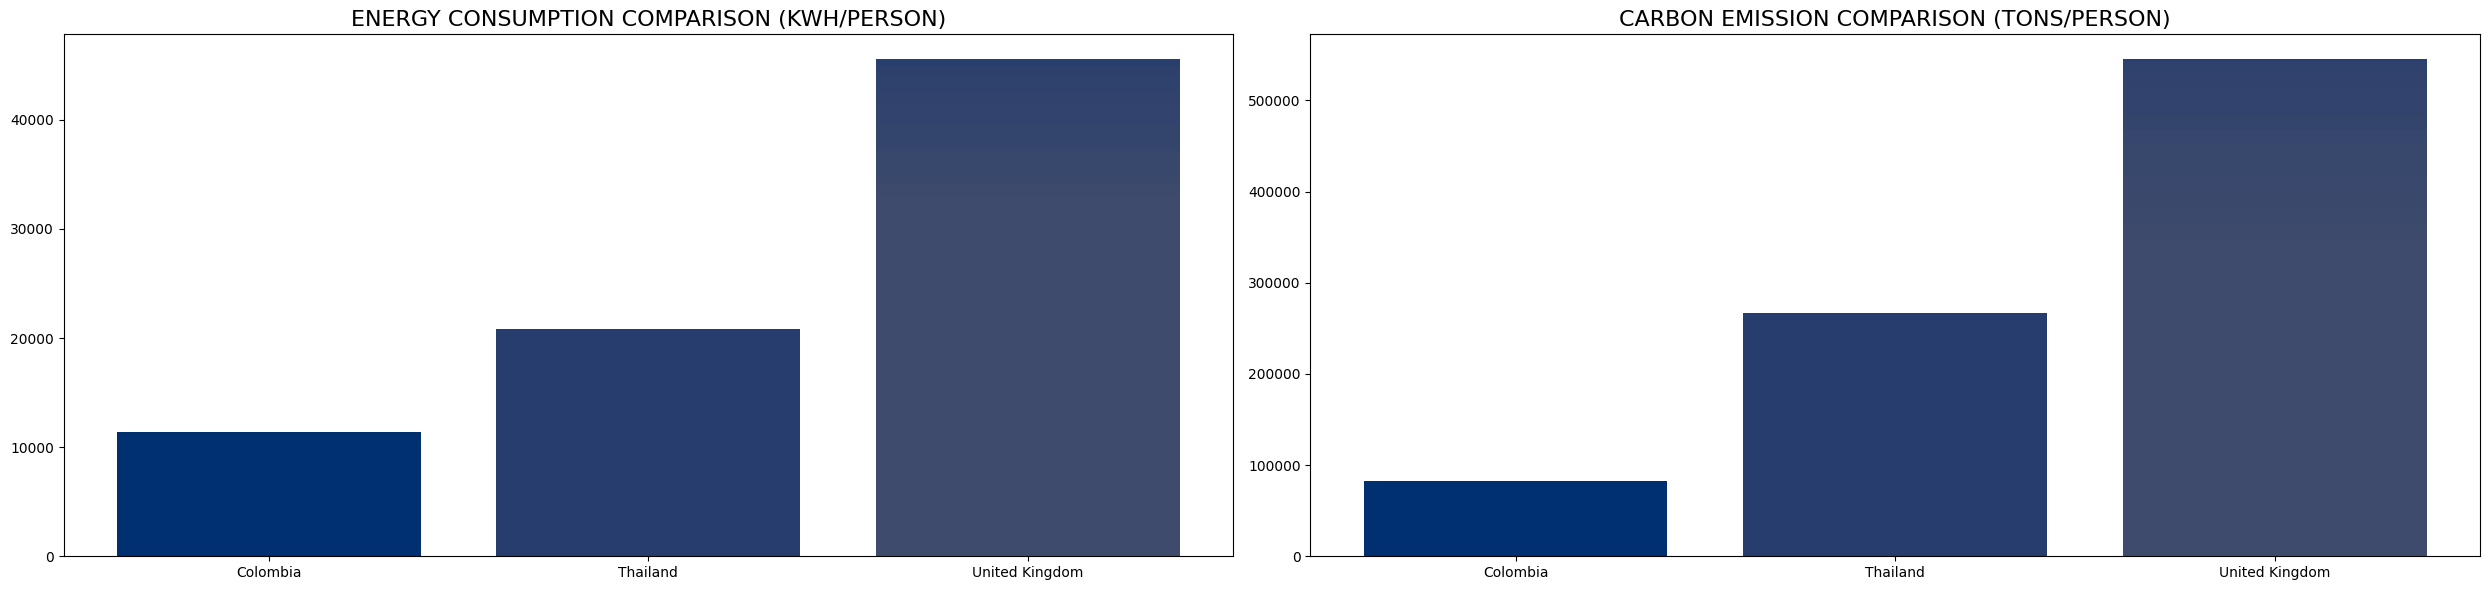

In [13]:
# BAR PLOT:

# PLOT THEM INTO THE SAME PLOT
plt.figure(figsize = (25,6))

# ENERGY
plt.subplot(1, 2, 1)
bar_plot(final_df,'TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)', 'ENERGY CONSUMPTION COMPARISON (KWH/PERSON)')

# CO2:
plt.subplot(1, 2, 2)
bar_plot(final_df,'TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY', 'CARBON EMISSION COMPARISON (TONS/PERSON)')

plt.tight_layout()

# CHECKING THE TRENDS:

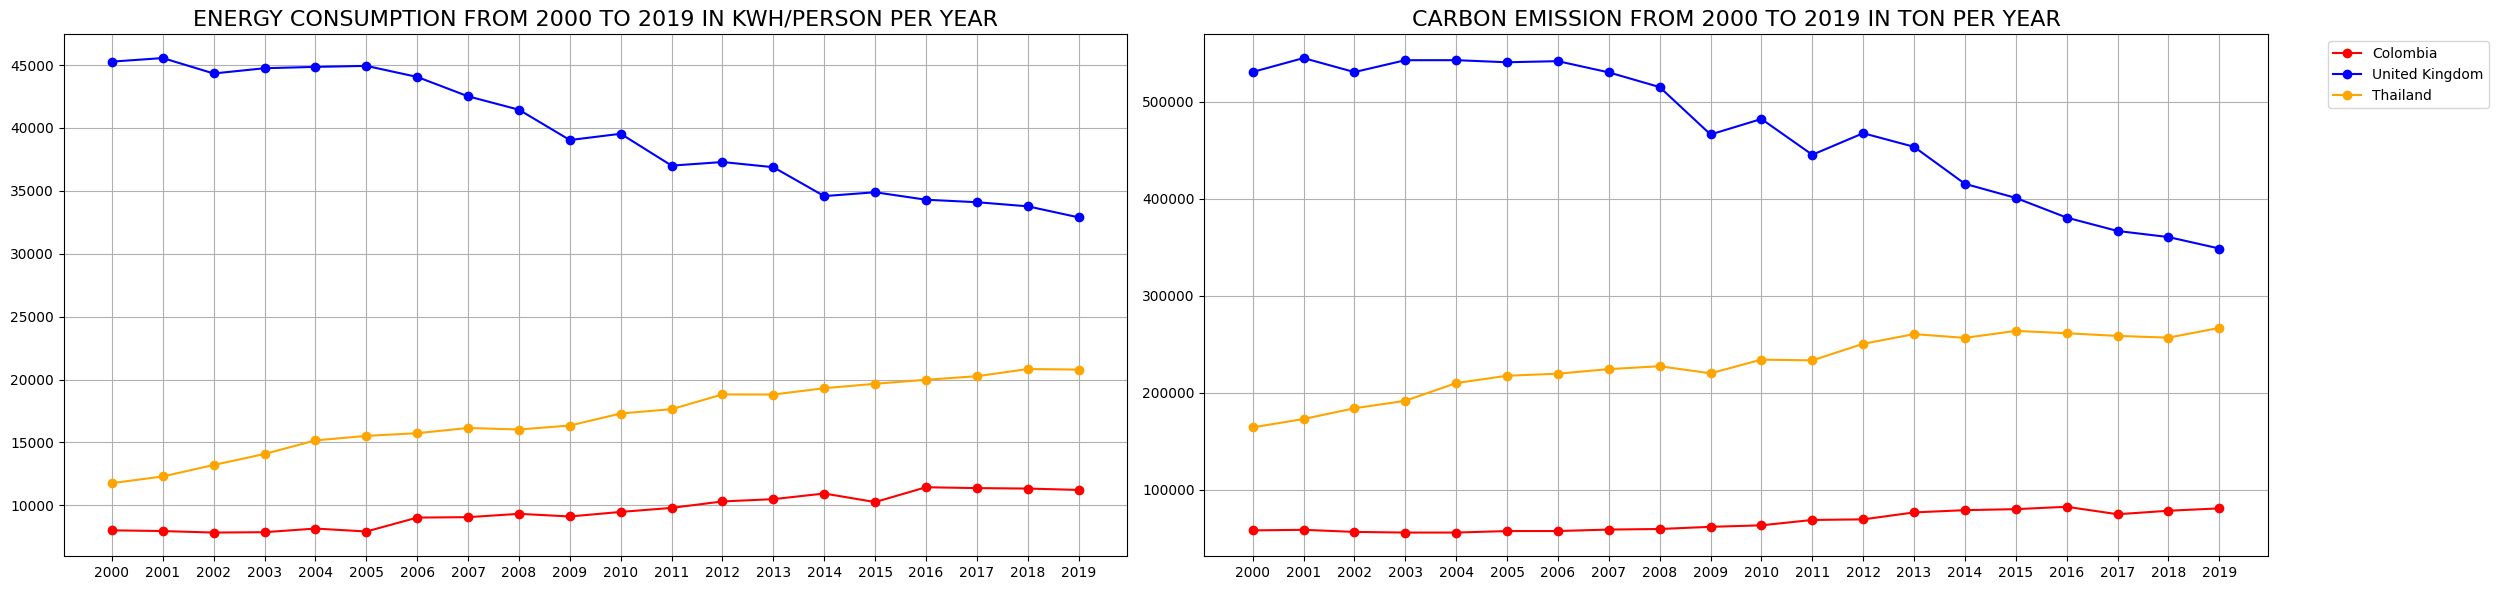

In [14]:
# RANGE TO PLOT (YEARS)
years = list(final_df['Year'].unique())

# GETTING THE DATA TO PLOT
# ENERGY:
colombia_energy = final_df[final_df['Entity'] == 'Colombia']['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']
uk_energy       = final_df[final_df['Entity']   == 'United Kingdom']['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']
thailand_energy = final_df[final_df['Entity']  == 'Thailand']['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']

# CO2:
colombia_co2 = final_df[final_df['Entity']  == 'Colombia']['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']
uk_co2       = final_df[final_df['Entity']  == 'United Kingdom']['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']
thailand_co2  = final_df[final_df['Entity'] == 'Thailand']['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']

# PLOT THEM INTO THE SAME PLOT
plt.figure(figsize = (25,6))

# PLOTTING ENERGY:
plt.subplot(1, 2, 1)
plot_trend(colombia_energy, uk_energy, thailand_energy, years, 'ENERGY CONSUMPTION FROM 2000 TO 2019 IN KWH/PERSON PER YEAR')
# PLOTTING CO2:
plt.subplot(1, 2, 2)
plot_trend(colombia_co2, uk_co2, thailand_co2, years, 'CARBON EMISSION FROM 2000 TO 2019 IN TON PER YEAR')

# LAYOUT
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# GROUPING ALL THE SELECTING COUNTRIES INTO ENERGY AND CO2:

In [15]:
# DIVIDING THE DATA TO REORGANIZE IT (ENERGY):
colombia_df                     = final_df[final_df['Entity'] == 'Colombia'].reset_index(drop=True)
thailand_df                     = final_df[final_df['Entity'] == 'Thailand'].reset_index(drop=True)
united_kingdom_df               = final_df[final_df['Entity'] == 'United Kingdom'].reset_index(drop=True)

# CREATING A NEW DATA FRAME (CARBON):
total_carbon                    = pd.DataFrame({'Year':final_df['Year'].unique()})
total_carbon['Colombia']        = colombia_df['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']
total_carbon['Thailand']        = thailand_df['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']
total_carbon['United Kingdom']  = united_kingdom_df['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']

# CREATING A NEW DATA FRAME:
total_energy                    = pd.DataFrame({'Year':final_df['Year'].unique()})
total_energy['Colombia']        = colombia_df['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']
total_energy['Thailand']        = thailand_df['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']
total_energy['United Kingdom']  = united_kingdom_df['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']

# INDEX YEAR ENERGY:
total_energy['Year'] = pd.to_datetime(total_energy['Year'], format='%Y')
total_energy.index = total_carbon['Year']

# INDEX YEAR CARBON:
total_carbon['Year'] = pd.to_datetime(total_carbon['Year'], format='%Y')
total_carbon.index = total_carbon['Year']

# DROPPING THE YEAR COLUMNS (NOW AN INDEX)
total_carbon = total_carbon.drop(columns='Year')
total_energy = total_energy.drop(columns='Year');

In [16]:
total_carbon

,Colombia,Thailand,United Kingdom
Year,,,
2000-01-01,58340.00000,164490.0000,530890.0000
2001-01-01,58940.00000,173160.0000,545260.0000
2002-01-01,56770.00046,184240.0055,530789.9780
2003-01-01,56110.00061,191929.9927,543039.9780
2004-01-01,56110.00061,210190.0024,543080.0171
2005-01-01,57639.99939,217770.0043,540919.9829
2006-01-01,57689.99863,219880.0049,542059.9976
2007-01-01,59180.00031,224589.9963,530500.0000
2008-01-01,59779.99878,227580.0018,515340.0269


In [17]:
total_energy

,Colombia,Thailand,United Kingdom
Year,,,
2000,8011.8125,11764.549,45275.645
2001,7953.8550,12293.458,45559.023
2002,7834.4710,13208.064,44332.900
2003,7863.6520,14080.671,44750.703
2004,8152.3345,15161.756,44856.600
2005,7917.9070,15521.235,44937.305
2006,9024.0930,15733.904,44057.820
2007,9058.0020,16149.867,42517.130
2008,9322.7670,16027.417,41451.902


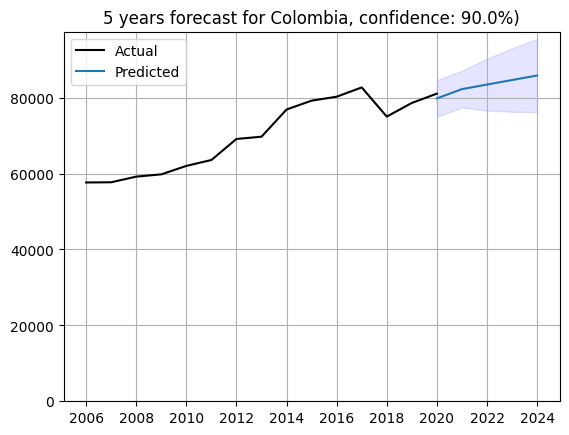

Column Name: Colombia
Actual Values: [80230.00336 82680.00031 74989.99786 78589.99634 81040.00092]
Predicted Values: [79784.73323053 82234.73781053 83429.47470105 84624.21159158
 85818.94848211]
Confidence Interval: [[74957.56791201 84611.89854904]
 [77407.57249201 87061.90312904]
 [76602.83203979 90256.11736231]
 [76263.31600338 92985.10717978]
 [76164.61784508 95473.27911913]]
Mean Absolute Error (MAE): 4028.634456736842
Mean Squared Error (MSE): 26174277.407208502
Root Mean Squared Error (RMSE): 5116.080277635262
Confidence Level: 0.9



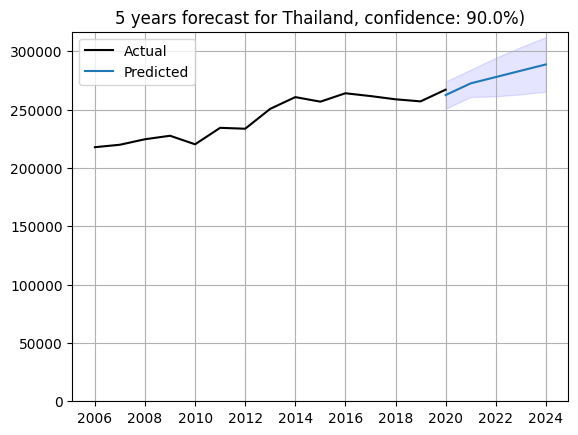

Column Name: Thailand
Actual Values: [264000.     261600.0061 258820.0073 257049.9878 267089.9963]
Predicted Values: [262449.98760526 272489.99610526 277889.99591053 283289.99571579
 288689.99552105]
Confidence Interval: [[250760.14520935 274139.83000118]
 [260800.15370935 284179.83850118]
 [261358.06225222 294421.92956883]
 [263042.5947536  303537.39667798]
 [265310.31072923 312069.68031288]]
Mean Absolute Error (MAE): 15869.999629473745
Mean Squared Error (MSE): 327951373.62287056
Root Mean Squared Error (RMSE): 18109.427755256944
Confidence Level: 0.9



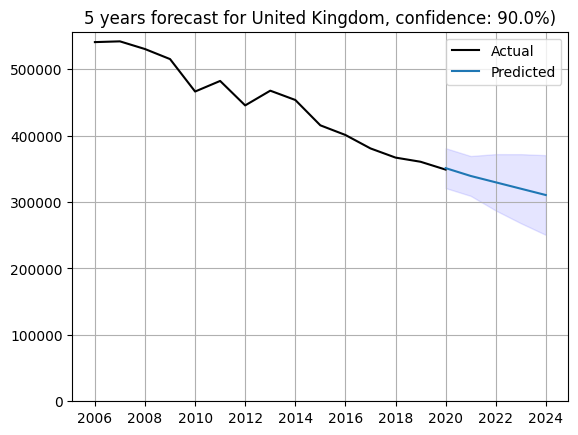

Column Name: United Kingdom
Actual Values: [401079.9866 380809.9976 367000.     360730.011  348920.0134]
Predicted Values: [351152.64328421 339342.64568421 329765.27796842 320187.91025263
 310610.54253684]
Confidence Interval: [[321135.5170232  381169.76954522]
 [309325.5194232  369359.77194522]
 [287314.65090664 372215.90503021]
 [268196.72247135 372179.09803391]
 [250576.29001482 370644.79505886]]
Mean Absolute Error (MAE): 41496.19777473684
Mean Squared Error (MSE): 1741996580.2149003
Root Mean Squared Error (RMSE): 41737.232541400015
Confidence Level: 0.9



In [18]:
# Foecasting by AutoARIMA
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
sktime_forecast(dataset=total_carbon, horizon=5, forecaster=forecaster, validation=False)